We begin by loading and inspecting the BBC News dataset. This includes both the training set (with labeled categories) and the test set (unlabeled). The following steps are performed in this section:

- Load data from CSV files
- Preview the dataset
- Display column types and basic info
- Check for missing values

This exploratory step is crucial to understanding the structure and cleanliness of the data before proceeding with preprocessing and model training.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

train_path = "/kaggle/input/learn-ai-bbc/BBC News Train.csv"
test_path = "/kaggle/input/learn-ai-bbc/BBC News Test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print("Training Data Sample:")
print(train_data.head())

print("\nTest Data Sample:")
print(test_data.head())

print("\nDataset Info:")
print(train_data.info())

print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())

print("Training Data Columns:", train_data.columns)
print("Test Data Columns:", test_data.columns)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Training Data Sample:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Test Data Sample:
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india

Category Distribution

We begin by visualizing the distribution of article categories in the training data. This helps us understand potential class imbalances that could influence both unsupervised and supervised model performance.

This plot gives an overview of how many examples are available for each news category. Having relatively balanced categories may help classifiers generalize better.

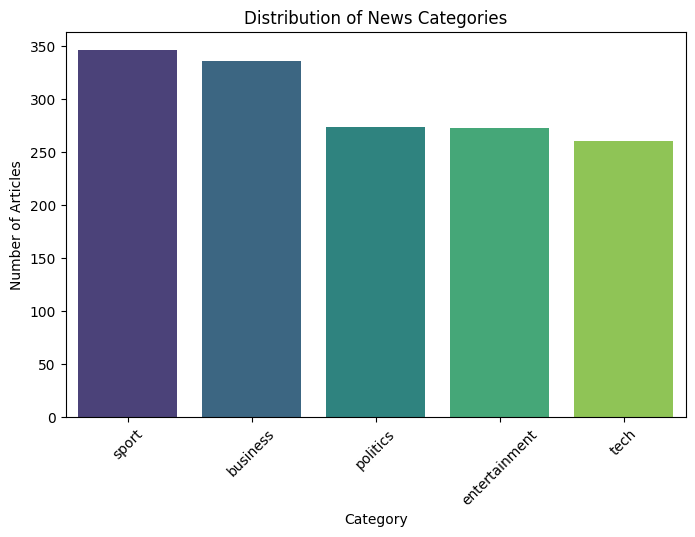

In [2]:
category_counts = train_data['Category'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.title("Distribution of News Categories")
plt.xticks(rotation=45)
plt.show()

Text Preprocessing

To prepare the raw text for analysis, we perform standard preprocessing steps:

- Convert text to lowercase
- Remove punctuation and numeric characters
- Tokenize the text into words
- Remove English stopwords ("the", "and", "is")

This step reduces noise and standardizes the text, making it suitable for feature extraction using techniques like TF-IDF.

Below we show a comparison of the original and cleaned text for one example:

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)  
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

train_data['Cleaned_Text'] = train_data['Text'].apply(preprocess_text)
test_data['Cleaned_Text'] = test_data['Text'].apply(preprocess_text)

print("Original Text Sample:\n", train_data['Text'].iloc[0])
print("\nCleaned Text Sample:\n", train_data['Cleaned_Text'].iloc[0])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Original Text Sample:
 worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs he

Word Frequency Visualization by Category

To better understand the key terms that appear in each news category, we generate Word Clouds. Word Clouds visually emphasize the most frequent words by size, helping to quickly identify the dominant vocabulary associated with each topic.

Each Word Cloud below corresponds to a different category in the dataset.

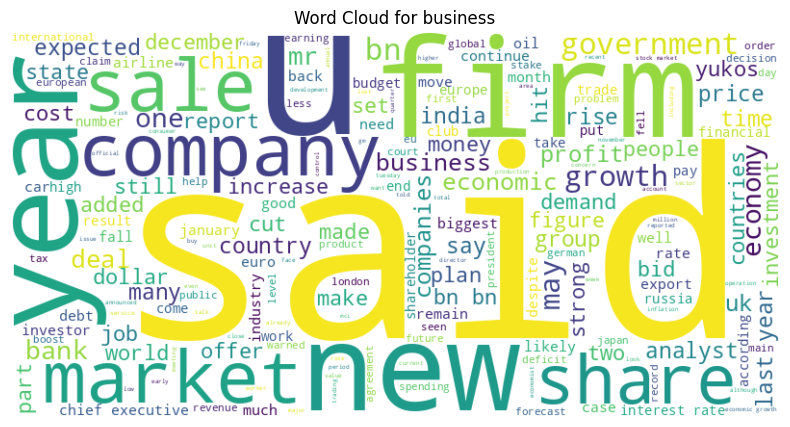

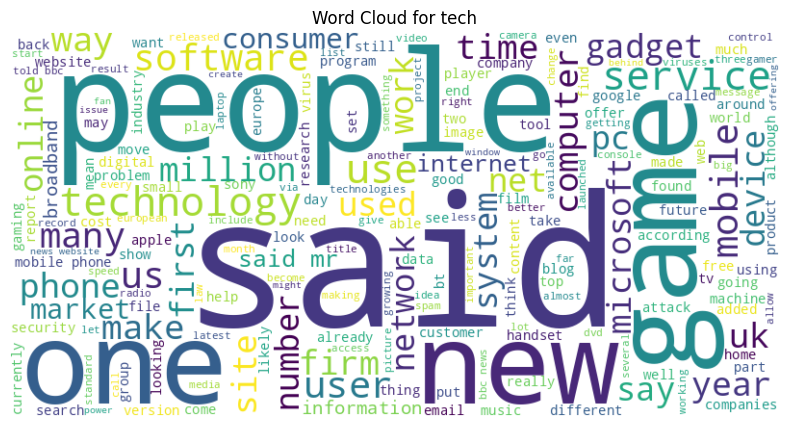

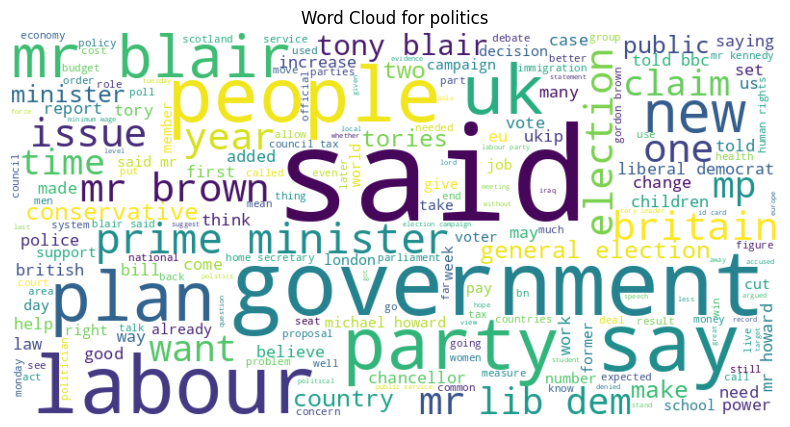

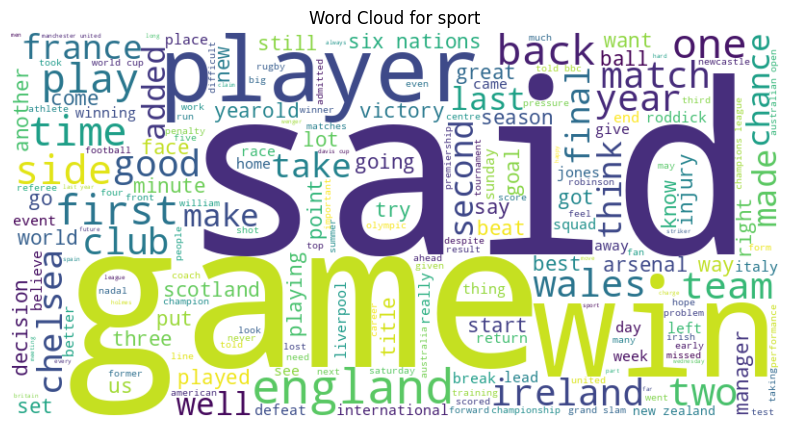

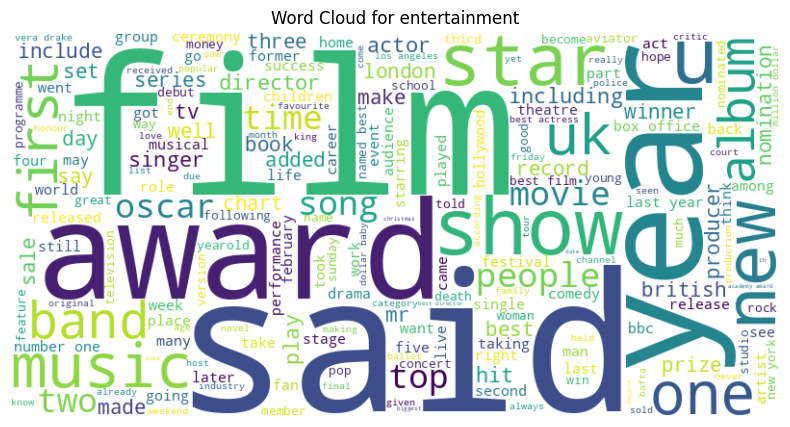

In [4]:
def plot_wordcloud(category):
    text = " ".join(train_data[train_data['Category'] == category]['Cleaned_Text'])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {category}")
    plt.show()

for cat in train_data['Category'].unique():
    plot_wordcloud(cat)

Feature Extraction: TF-IDF Vectorization

To convert cleaned text into numerical format for modeling, we use TF-IDF (Term Frequency-Inverse Document Frequency). This method assigns higher weight to words that are frequent in a document but rare across other documents.

We extract the top 5,000 features and remove standard English stop words during vectorization. This sparse matrix will serve as the input for both unsupervised and supervised learning models.

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Cleaned_Text'])

X_test_tfidf = tfidf_vectorizer.transform(test_data['Cleaned_Text'])

tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("Sample TF-IDF Features:\n", tfidf_df.head())


Sample TF-IDF Features:
    abbas  abc  ability      able  abroad  absence  absolute  absolutely  \
0    0.0  0.0      0.0  0.000000     0.0      0.0       0.0         0.0   
1    0.0  0.0      0.0  0.000000     0.0      0.0       0.0         0.0   
2    0.0  0.0      0.0  0.000000     0.0      0.0       0.0         0.0   
3    0.0  0.0      0.0  0.025822     0.0      0.0       0.0         0.0   
4    0.0  0.0      0.0  0.000000     0.0      0.0       0.0         0.0   

   abuse  abused  ...  youngest  youngsters  youth  yuan  yugansk  \
0    0.0     0.0  ...       0.0    0.000000    0.0   0.0      0.0   
1    0.0     0.0  ...       0.0    0.000000    0.0   0.0      0.0   
2    0.0     0.0  ...       0.0    0.000000    0.0   0.0      0.0   
3    0.0     0.0  ...       0.0    0.047527    0.0   0.0      0.0   
4    0.0     0.0  ...       0.0    0.000000    0.0   0.0      0.0   

   yuganskneftegas  yukos  zealand  zero  zone  
0              0.0    0.0      0.0   0.0   0.0  
1          

Supervised Learning: Multinomial Naïve Bayes

As a baseline supervised model, we use Multinomial Naïve Bayes, which is well-suited for text classification problems with word frequency inputs like TF-IDF.

We train the model using the TF-IDF vectors extracted from the cleaned training text and evaluate it on the same set to gauge initial performance.

In [7]:
y_train = train_data['Category']

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_train_pred = nb_model.predict(X_train_tfidf)

print("Naïve Bayes Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report on Training Data:")
print(classification_report(y_train, y_train_pred))

Naïve Bayes Training Accuracy: 0.9919463087248322

Classification Report on Training Data:
               precision    recall  f1-score   support

     business       0.99      0.99      0.99       336
entertainment       1.00      0.99      0.99       273
     politics       1.00      0.99      0.99       274
        sport       0.99      1.00      1.00       346
         tech       0.98      0.99      0.98       261

     accuracy                           0.99      1490
    macro avg       0.99      0.99      0.99      1490
 weighted avg       0.99      0.99      0.99      1490



In [9]:
y_test_pred = nb_model.predict(X_test_tfidf)

submission = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': y_test_pred})

submission.to_csv("submission.csv", index=False)

submission.to_csv("/kaggle/working/submission.csv", index=False)

print("Files in /kaggle/working/:", os.listdir("/kaggle/working/"))

print("Submission file created successfully!")

Files in /kaggle/working/: ['.virtual_documents', 'submission.csv']
Submission file created successfully!


In [10]:
print("Current directory:", os.getcwd())
print("Files in directory:", os.listdir())

Current directory: /kaggle/working
Files in directory: ['.virtual_documents', 'submission.csv']


In [13]:
#1
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from math import sqrt

data = {
    'Movie1': [5, 4, 1, 1, np.nan],
    'Movie2': [3, np.nan, 1, np.nan, 1],
    'Movie3': [np.nan, np.nan, np.nan, np.nan, 5],
    'Movie4': [1, 1, 5, 4, 4]
}

ratings_df = pd.DataFrame(data, index=['User1', 'User2', 'User3', 'User4', 'User5'])

print("Original Ratings Matrix:")
display(ratings_df)

ratings_filled = ratings_df.fillna(0)

nmf = NMF(n_components=2, init='random', random_state=42, max_iter=1000)
W = nmf.fit_transform(ratings_filled)
H = nmf.components_

reconstructed = np.dot(W, H)
reconstructed_df = pd.DataFrame(reconstructed, index=ratings_df.index, columns=ratings_df.columns)

print("Reconstructed Ratings Matrix:")
display(reconstructed_df)

true_vals = []
pred_vals = []

for row in ratings_df.index:
    for col in ratings_df.columns:
        if not pd.isna(ratings_df.loc[row, col]):
            true_vals.append(ratings_df.loc[row, col])
            pred_vals.append(reconstructed_df.loc[row, col])

rmse = sqrt(mean_squared_error(true_vals, pred_vals))
print(f"Corrected RMSE: {rmse:.4f}")


Original Ratings Matrix:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Movie1,Movie2,Movie3,Movie4
User1,5.0,3.0,NaN,1
User2,4.0,NaN,NaN,1
User3,1.0,1.0,NaN,5
User4,1.0,NaN,NaN,4
User5,NaN,1.0,5.0,4


Reconstructed Ratings Matrix:


,Movie1,Movie2,Movie3,Movie4
User1,5.255784,1.993124,0.000000,1.455202
User2,3.504276,1.328908,0.000000,0.970251
User3,1.313064,0.944179,1.949552,3.945961
User4,0.981388,0.721816,1.527586,3.078743
User5,0.000000,0.650091,2.840191,5.219003


Corrected RMSE: 0.8712


Part 1: Matrix Factorization using Sklearn's NMF

We load a small movie ratings dataset and apply non-negative matrix factorization (NMF) using sklearn. The matrix has missing values (NaNs) that we impute with zeros before applying NMF. We then reconstruct the matrix and compute RMSE on known values to evaluate performance.

Part 2: 
Non-negative Matrix Factorization (NMF) is a linear decomposition technique that aims to approximate a non-negative matrix by the product of two lower-dimensional non-negative matrices. In recommendation systems, NMF can be used to predict missing ratings by learning latent features representing users and items.

While this approach is mathematically sound, our implementation using sklearn’s NMF resulted in an RMSE of 0.8712, indicating a moderate prediction error. Here are the reasons why NMF may not perform as well as other methods like similarity-based or baseline models:

Limitations:

- Sensitivity to Missing Data:  
  NMF requires a fully populated matrix. In practice, missing values are imputed (e.g., filled with zeros), which introduces bias and distorts the true rating patterns.

- Lack of Personalization:
  Unlike user-user or item-item collaborative filtering, which directly compares user or item behavior, NMF captures latent features that may overlook user-specific preferences, especially in small datasets.

- Overfitting Risk:
  When the dataset is small or sparse, NMF can easily overfit, particularly if the number of components is not well-tuned.

- No Implicit Feedback Handling:  
  NMF in sklearn is designed for explicit feedback (e.g., numeric ratings), and it lacks built-in mechanisms to handle implicit feedback (like clicks, views, or dwell time).

Suggestions for Improvement:

- Regularization:
  Introduce L1 or L2 regularization to reduce overfitting during matrix factorization.

- Better Imputation Techniques:
  Instead of zero-filling, use smarter imputation like item or user means to initialize missing values.

- Try Other Libraries:
  Use recommender system-specific libraries like Surprise, LightFM, or implicit, which are better suited for handling missing data and offer more robust tuning.

- Hybrid Approaches: 
  Combine NMF with similarity-based methods or supervised learning models for improved prediction performance.

In conclusion, while NMF offers a principled unsupervised approach, it falls short in certain areas, particularly on sparse or small datasets. Combining it with more tailored strategies often yields better real-world results.
